In [1]:
import os

from ml.eval import eval_model

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline, ModelPipeline

from tensorflow import keras


from cfg import *

from livelossplot import PlotLossesKerasTF

name = 'MyResCNN'

/home/jelinek/recetox/histoseg/notebooks/Residual


In [2]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1',
                        kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])  # SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X


class MySimpleCnn_Feit(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size = 256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1, 1), pool_size=(3, 3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3, 3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5, 5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(p1)

        output_layer = keras.layers.concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer

    @staticmethod
    def get_compiled_model(input_shape=(256, 256, 3)):
        X_input = keras.layers.Input(input_shape)

        X = keras.layers.ZeroPadding2D((3, 3))(X_input)

        X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = keras.layers.Activation('relu')(X)
        X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
        X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
        X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

        X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
        X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
        X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
        X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

        X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
        X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

        X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
        X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
        X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

        X = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        X = keras.layers.Flatten()(X)
        X = keras.layers.Dense(units=11, activation='softmax')(X)

        model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
        
        model.summary()

        return model

    def _train_model(self, data_train, data_valid):

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, PlotLossesKerasTF()])

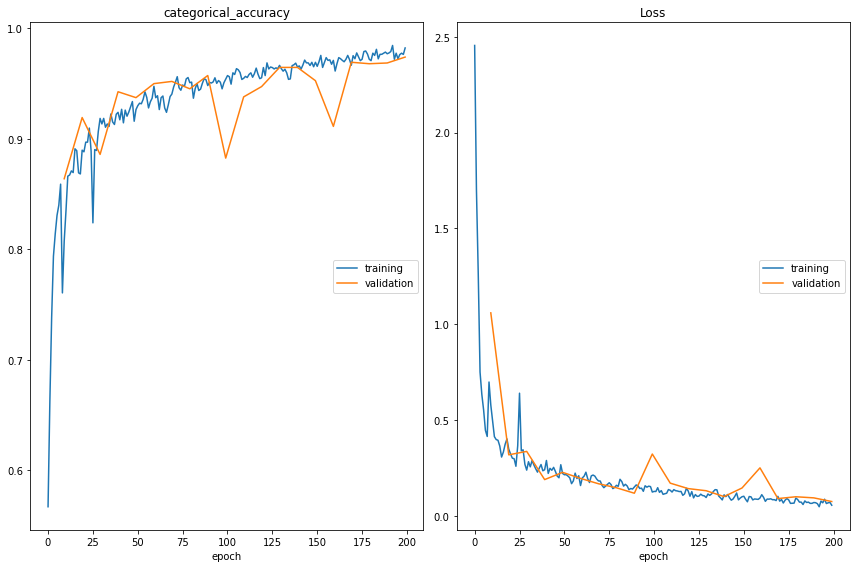

categorical_accuracy
	training         	 (min:    0.567, max:    0.984, cur:    0.982)
	validation       	 (min:    0.864, max:    0.974, cur:    0.974)
Loss
	training         	 (min:    0.049, max:    2.454, cur:    0.057)
	validation       	 (min:    0.076, max:    1.060, cur:    0.076)
250/250 [==============================] - 30s 120ms/step - loss: 0.0570 - categorical_accuracy: 0.9822 - val_loss: 0.0763 - val_categorical_accuracy: 0.9740
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 1.2769ms
Confusion Matrix
[[330   1   0   1   2   1   0   0   0   0   0]
 [  1  57   5   1   0   0   0   0   0   0   0]
 [  0   2 142   0   1   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  0   1   2   2 539   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  1   1   1   0   0   0  72   2   0   0   0]
 [  0   0   3   0   0   0   0  83   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   1   0   0   0   0   0   

In [3]:
pipeline = MySimpleCnn_Feit(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                            valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [4]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [5]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [6]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         64, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Post-processing image...
Processing grid point 166284 out of 166284
Processing image took 702.7282440662384 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 399840 out of 399840
Processing image took 1688.899020910263 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 386308 out of 386308
Processing image took 1624.6889879703522 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 880112 out of 880112
Processing image took 3703.5309031009674 seconds
Aggregated evaluation: 
[[122901   1411   1683     90    106     29      2    262     63      0
    5645]
 [   739   8980   1476   2608   1932     32    654   1830     63      0
     891]
 [   593   2240   4484   1329    452     23    951   1299     86      0
    1649]
 [    44    141      1    275      1      0      0      0    222      0
    2479]
 [   365   1513    976  15340  42414      5   1112